In [2]:
import sys
import numpy
from time import time
from matplotlib import pyplot
from scipy.stats import norm
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection

In [3]:
a = sys.path.append('/home/delimar/Documents/sources/')

In [4]:
from codes import grids, auxiliars, statistical, prism, plot, filtering, derivative, equivalentlayer, sphere

In [5]:
# Numero de pontos e shape do dado
nx, ny = 40, 40
area = (-5000., 5000., -5000., 5000.)
shape = (nx, ny)
xo, yo, zo = grids.regular_grid(area, shape, -150.)

# Teste de validação

In [6]:
#intensity = 6.
#inc, dec, incs, decs = 0., 0., 0., 0. 
inc, dec = 10., 15.
incs, decs = 0., 0.

In [7]:
prisma = [1500., 2500., 1500., 2500., 200., 1200.]
dipolo = [-2000., -2000., 1000., 1000.]
#dipolo = [-2500., 2500., -2500., 2500., 3000., 4000.]

In [8]:
x1, x2, y1, y2 = (-3000., -1000., -3000., -1000.)
radius = 0.5 * min(x2 - x1, y2 - y1)
angles = numpy.linspace(0, 2*numpy.pi, (nx*ny) + 1)[:-1]
xs = 0.5*(x1 + x2) + radius*numpy.cos(angles)
ys = 0.5*(y1 + y2) + radius*numpy.sin(angles)

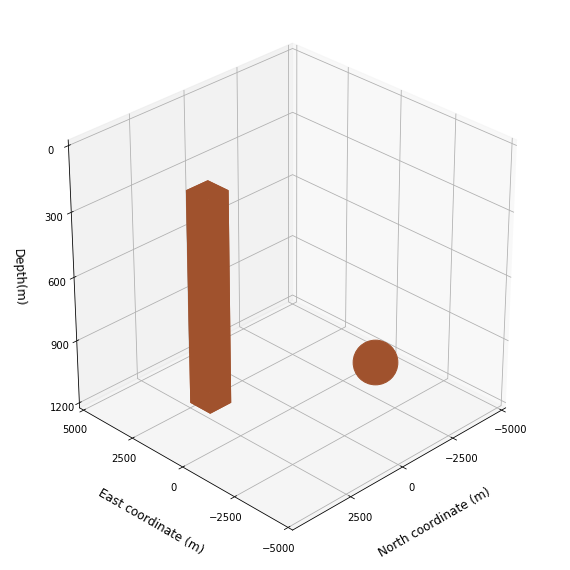

In [9]:
figure = pyplot.figure(figsize=(8,8))
ax = figure.gca(projection = '3d')

x1a, x2a, y1a, y2a, z1a, z2a = prisma
v1a = numpy.array([[x1a, y1a, z2a], [x1a, y2a, z2a], [x2a, y2a, z2a], [x2a, y1a, z2a], 
                 [x1a, y1a, z1a], [x1a, y2a, z1a], [x2a, y2a, z1a], [x2a, y1a, z1a]])
vertices1 = [[v1a[0],v1a[1],v1a[2],v1a[3]], [v1a[0],v1a[1],v1a[5],v1a[4]], [v1a[1],v1a[2],v1a[6],v1a[5]],
            [v1a[2],v1a[3],v1a[7],v1a[6]], [v1a[3],v1a[0],v1a[4],v1a[7]], [v1a[4],v1a[5],v1a[6],v1a[7]]]
pc5a = Poly3DCollection(vertices1, alpha = 1., linewidths = 0., edgecolors = 'k')
pc5a.set_facecolor('sienna')
ax.add_collection3d(pc5a)

ax.scatter([-2000.], [-2000.], [1000.], color = 'sienna', s = 2000, zdir= 'z')

x_scale = 1.
y_scale = 1.
z_scale = 1.
scale=numpy.diag([x_scale, y_scale, z_scale, 1.0])
scale=scale*(1.0/scale.max())
scale[3,3] = 1.
def short_proj():
    return numpy.dot(Axes3D.get_proj(ax), scale)
ax.get_proj=short_proj
ax.set_xlabel('North coordinate (m)', size = 12, labelpad = 20)
ax.set_ylabel('East coordinate (m)', size = 12, labelpad = 20)
ax.set_zlabel('Depth(m)', size = 12, labelpad = 15)
ax.set_xlim(xo.min(), xo.max())
ax.set_ylim(yo.min(), yo.max())
ax.set_zlim(0., 1200.)
ax.set_xticks(numpy.arange(xo.min(), xo.max(), 2500))
ax.set_yticks(numpy.linspace(yo.min(), yo.max(), 5))
ax.set_zticks(numpy.linspace(0., 1200., 5))
ax.view_init(210, 135)
pyplot.tight_layout(True)

pyplot.show()

In [10]:
tf = prism.prism_tf(xo, yo, zo, prisma, 6., inc, dec, incs, decs) + \
        sphere.sphere_tfa(xo, yo, zo, dipolo, 6., inc, dec, incs, decs)

In [11]:
print 'Anomalia magnetica:'
_ = statistical.analysis(tf, 'nT')

Anomalia magnetica:
Minimum:    -1578.2870 nT
Maximum:    451.9392 nT
Mean value: -17.0038 nT
Variation:  2030.2263 nT


In [12]:
tf = auxiliars.noise_normal_dist(tf, 5., 0.25)

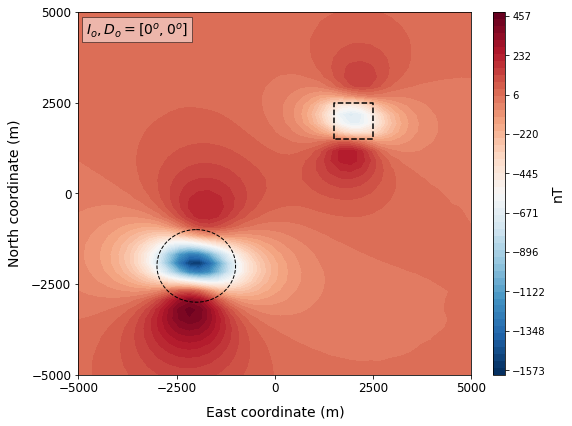

In [13]:
pyplot.figure(figsize=(8,6))
cs = pyplot.contourf(yo.reshape(shape), xo.reshape(shape), tf.reshape(shape), 
                50, cmap = pyplot.cm.RdBu_r)
plot.draw_prism(prisma[:4], linewidth = 0.5, style = 'k--', xy2ne = True)
pyplot.plot(ys, xs, 'k--', linewidth = 1.)
pyplot.text(-4800., 4400., '$I_o, D_o = [0^o, 0^o]$', 
            fontsize = 14.,bbox=dict(facecolor='white', edgecolor='k', alpha = 0.5))
pyplot.xlabel('East coordinate (m)', fontsize = 14, labelpad = 10)
pyplot.ylabel('North coordinate (m)', fontsize = 14, labelpad = 10)
pyplot.xticks(numpy.linspace(yo.min(), yo.max(), 5), fontsize = 12)
pyplot.yticks(numpy.linspace(xo.min(), xo.max(), 5), fontsize = 12)
cb = pyplot.colorbar(cs, aspect = 30, fraction = 0.04, orientation = 'vertical', pad = 0.05)
cb.set_ticks(numpy.linspace(tf.min(), tf.max(), 10))
cb.set_clim(tf.min(), tf.max())
cb.set_label('nT', fontsize = 14, labelpad = 5)
pyplot.tight_layout(True)

pyplot.show()

In [14]:
area_layer = area
shape_layer = (15, 15)
level = 1200.

In [15]:
xlayer, ylayer, zlayer = grids.regular_grid(area, shape_layer, level)
eqlayer = equivalentlayer.layer(area_layer, shape_layer, level)
data = [xo, yo, zo, tf]
_, tf_pred = equivalentlayer.fit_layer(data, shape, eqlayer, shape_layer, 0.00001, inc, dec, incs, decs)

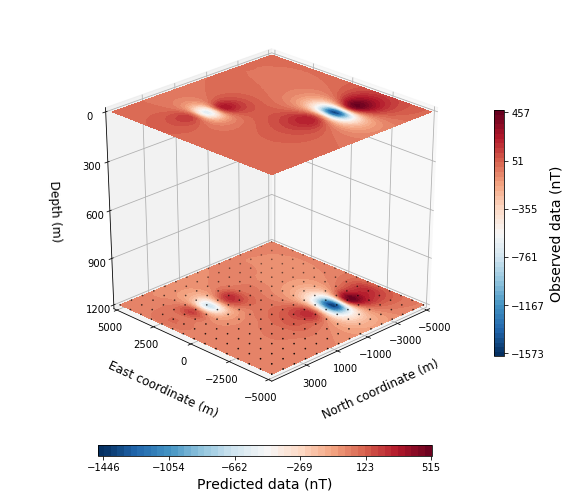

In [16]:
figure = pyplot.figure(figsize=(8,7))
ax = figure.gca(projection = '3d')
p1 = ax.contourf(xo.reshape(shape), yo.reshape(shape), tf.reshape(shape),
                 50, zdir='z', offset = 0., cmap = 'RdBu_r',
                  vmin = numpy.min(tf), vmax = numpy.max(tf))
cbar1 = pyplot.colorbar(p1, aspect = 25, fraction = 0.02, orientation = 'vertical', pad = -0.05)
cbar1.set_label('Observed data (nT)', fontsize = 14, rotation = 90.)
cbar1.set_ticks(numpy.linspace(tf.min(), tf.max(), 6))

p2 = ax.contourf(xo.reshape(shape), yo.reshape(shape), tf_pred.reshape(shape),
                 50, zdir='z', offset = level, cmap = 'RdBu_r',
                  vmin = numpy.min(tf_pred), vmax = numpy.max(tf_pred))
ax.scatter3D(xlayer.reshape(shape_layer), ylayer.reshape(shape_layer), zlayer.reshape(shape_layer), 
             s = 0.5, c = 'k')
cbar2 = pyplot.colorbar(p2, aspect = 30, fraction = 0.025, orientation = 'horizontal', pad = 0.05)
cbar2.set_label('Predicted data (nT)', fontsize = 14, rotation = 0.)
cbar2.set_ticks(numpy.linspace(tf_pred.min(), tf_pred.max(), 6))

x_scale = 1.
y_scale = 1.
z_scale = 1.25
scale=numpy.diag([x_scale, y_scale, z_scale, 1.0])
scale=scale*(1.0/scale.max())
scale[3,3] = 1.
def short_proj():
    return numpy.dot(Axes3D.get_proj(ax), scale)
ax.get_proj=short_proj
ax.set_xlabel('North coordinate (m)', size = 12, labelpad = 20)
ax.set_ylabel('East coordinate (m)', size = 12, labelpad = 20)
ax.set_zlabel('Depth (m)', size = 12, labelpad = 20)
ax.set_xlim(xo.min(), xo.max())
ax.set_xticks(numpy.arange(xo.min(), xo.max(), 2000.))
ax.set_yticks(numpy.linspace(yo.min(), yo.max(), 5))
ax.set_zticks(numpy.linspace(0., level, 5))
ax.set_ylim(yo.min(), yo.max())
ax.set_zlim(0., level)
ax.view_init(210, 135)
pyplot.tight_layout(True)

pyplot.show()

In [17]:
residuo = tf - tf_pred

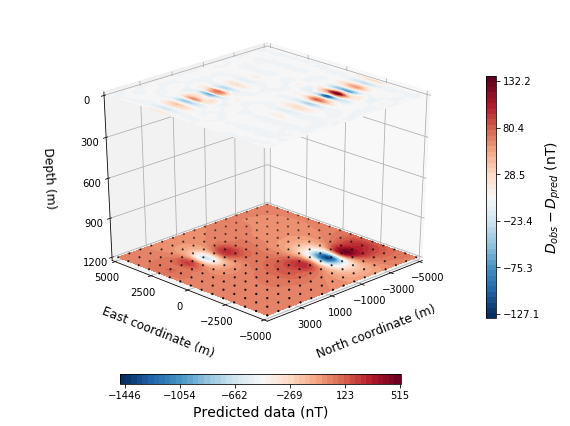

In [18]:
figure = pyplot.figure(figsize=(8,6))
ax = figure.gca(projection = '3d')
#ax.set_title('Ajuste de dados via camada equivalente', size = 16, pad = 10)
p1 = ax.contourf(xo.reshape(shape), yo.reshape(shape), residuo.reshape(shape),
                 50, zdir='z', offset = 0., cmap = 'RdBu_r',
                  vmin = numpy.min(residuo), vmax = numpy.max(residuo))
cbar1 = pyplot.colorbar(p1, aspect = 25, fraction = 0.02, orientation = 'vertical', pad = -0.05)
cbar1.set_label('$D_{obs} - D_{pred}$ (nT)', fontsize = 14, rotation = 90.)
cbar1.set_ticks(numpy.linspace(residuo.min(), residuo.max(), 6))

p2 = ax.contourf(xo.reshape(shape), yo.reshape(shape), tf_pred.reshape(shape),
                 50, zdir='z', offset = level, cmap = 'RdBu_r',
                  vmin = numpy.min(tf_pred), vmax = numpy.max(tf_pred))
ax.scatter3D(xlayer.reshape(shape_layer), ylayer.reshape(shape_layer), zlayer.reshape(shape_layer), 
             s = 1.5, c = 'k')
cbar2 = pyplot.colorbar(p2, aspect = 30, fraction = 0.025, orientation = 'horizontal', pad = 0.05)
cbar2.set_label('Predicted data (nT)', fontsize = 14, rotation = 0.)
cbar2.set_ticks(numpy.linspace(tf_pred.min(), tf_pred.max(), 6))

x_scale = 1.
y_scale = 1.
z_scale = 1.25
scale=numpy.diag([x_scale, y_scale, z_scale, 1.0])
scale=scale*(1.0/scale.max())
scale[3,3] = 1.
def short_proj():
    return numpy.dot(Axes3D.get_proj(ax), scale)
ax.get_proj=short_proj
ax.set_xlabel('North coordinate (m)', size = 12, labelpad = 20)
ax.set_ylabel('East coordinate (m)', size = 12, labelpad = 20)
ax.set_zlabel('Depth (m)', size = 12, labelpad = 20)
ax.set_xlim(xo.min(), xo.max())
ax.set_xticks(numpy.arange(xo.min(), xo.max(), 2000.))
ax.set_yticks(numpy.linspace(yo.min(), yo.max(), 5))
ax.set_zticks(numpy.linspace(0., level, 5))
ax.set_ylim(yo.min(), yo.max())
ax.set_zlim(0., level)
ax.view_init(210, 135)
pyplot.tight_layout(True)

pyplot.show()

In [19]:
res_mu = numpy.mean(residuo)
res_sigma = numpy.std(residuo)

/home/delimar/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


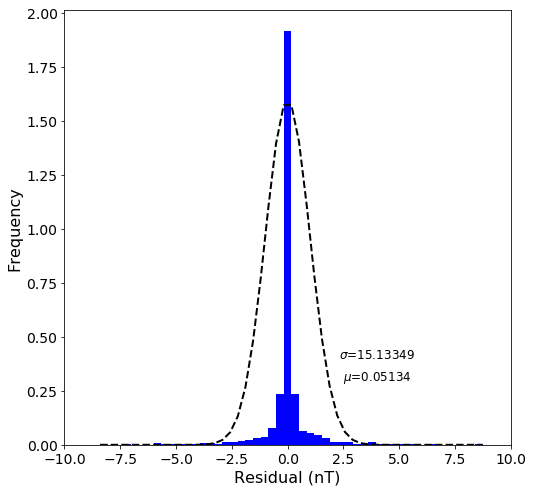

In [20]:
pyplot.figure(figsize=(8,8))
s = (residuo - res_mu) / res_sigma
s = numpy.ravel(s)
nbins = int(numpy.max(s) - numpy.min(s))
n, bins, patches = pyplot.hist(s, 50, normed = True, facecolor = 'blue', alpha = 1.)
y_hist = norm.pdf(bins, numpy.mean(s), numpy.std(s))
pyplot.plot(bins, 4*y_hist, 'k--', linewidth = 2)
pyplot.text(4,0.3, '$\mu$=%0.5f' % (res_mu), horizontalalignment = 'center', fontsize = 12)
pyplot.text(4,0.4, '$\sigma$=%0.5f' % (res_sigma), horizontalalignment = 'center', fontsize = 12)
pyplot.xlabel('Residual (nT)' , fontsize = 16)
pyplot.ylabel('Frequency', fontsize = 16)
pyplot.xlim(-10,10)
pyplot.xticks(fontsize = 14)
pyplot.yticks(fontsize = 14)
#pyplot.savefig('cap04a-histograma.png', dpi = 300, bbox_inches = 'tight', transparent = True)
#pyplot.savefig('cap04a-histograma.pdf', dpi = 300, bbox_inches = 'tight', transparent = True)
pyplot.show()

In [21]:
xobs = xo.reshape(shape)
yobs = yo.reshape(shape)
zobs = zo.reshape(shape)
dobs = tf.reshape(shape)

In [22]:
incfull = numpy.linspace(-90., 90., 37)
decfull = numpy.linspace(-90., 90., 13)
Dfull, Ifull = numpy.meshgrid(decfull, incfull)
resfull = numpy.zeros_like(Dfull)

In [23]:
initial = time()
for k2, d in enumerate(decfull):
    for k1, i in enumerate(incfull):
        if i >= -15. or i <= 15.:
            rtp = equivalentlayer.rtp_layer(data, shape, eqlayer, shape_layer, 0.00001, inc, dec, i, d)
            resfull[k1,k2] = statistical.cccoef(derivative.totalgrad(xobs, yobs, rtp.reshape(shape)),
                                     derivative.zderiv(xobs, yobs, rtp.reshape(shape)))    
        else:
            rtp = filtering.reduction(xobs, yobs, dobs, inc, dec, i, d)
            resfull[k1,k2] = statistical.cccoef(derivataive.totalgrad(xobs, yobs, rtp),
                                     derivative.zderiv(xobs, yobs, rtp))            
final = time()
print 'Tempo de calculo (sec): %.3f' % (final-initial)

Tempo de calculo (sec): 344.054


In [24]:
print 'Maxima correlacao:', resfull.max()
print 'Minima correlacao:', resfull.min()

Maxima correlacao: 0.798668869679
Minima correlacao: -0.169827310962


In [25]:
imaxfull, jmaxfull = numpy.where(resfull == resfull.max())
incmaxfull = float(Ifull[imaxfull, jmaxfull])
decmaxfull = float(Dfull[imaxfull, jmaxfull])
print '(I,D) maximo:', incmaxfull, decmaxfull

(I,D) maximo: 0.0 0.0


/home/delimar/anaconda2/lib/python2.7/site-packages/matplotlib/contour.py:1004: UserWarning: The following kwargs were not used by contour: 'linestyle'
  s)


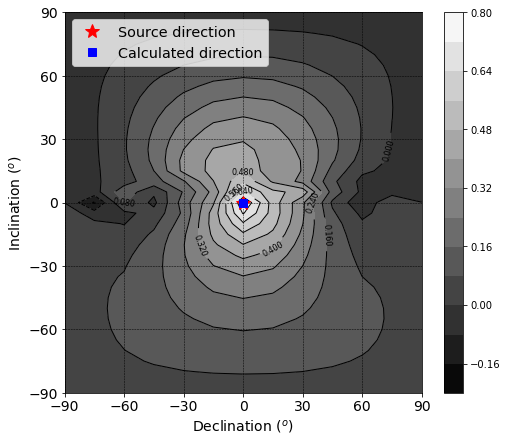

In [26]:
pyplot.figure(figsize=(8, 7))
fig5c = pyplot.contour(Dfull, Ifull, resfull, 15, colors = 'k', linestyle = 'solid', linewidths = 1)
pyplot.contourf(Dfull, Ifull, resfull, 15, cmap = pyplot.cm.gray)
pyplot.clabel(fig5c, fontsize = 8)
pyplot.plot(decs, incs, 'r*', label = 'Source direction', markersize = 15)
pyplot.plot(decmaxfull, incmaxfull, 'bs', label = 'Calculated direction', markersize = 8)
pyplot.xlabel('Declination $(^o)$', fontsize = 14)
pyplot.ylabel('Inclination $(^o)$', fontsize = 14)
pyplot.xticks(numpy.linspace(Dfull.min(), Dfull.max(), 7), fontsize = 14)
pyplot.yticks(numpy.linspace(Ifull.min(), Ifull.max(), 7), fontsize = 14)
pyplot.legend(loc = 'upper left', fontsize = 'x-large')
pyplot.colorbar()
pyplot.grid(color = 'k', linestyle='--', linewidth = .5)
pyplot.show()

In [27]:
areai = (-90., 90., -90., 90)
shapei = (181, 181)
Inci, Deci = grids.regular_grid(areai, shapei)
datares = resfull.reshape(resfull.size)

In [28]:
datai = griddata((Ifull.reshape(Ifull.size), Dfull.reshape(Dfull.size)), 
                 datares, (Inci, Deci), method = 'cubic')
datai = datai.reshape(shapei)

In [29]:
imaxi, jmaxi = numpy.where(datai == datai.max())
inci = float(Inci.reshape(shapei)[imaxi, jmaxi])
deci = float(Deci.reshape(shapei)[imaxi, jmaxi])
print '(I,D) maximo:', inci, deci

(I,D) maximo: 0.0 2.0


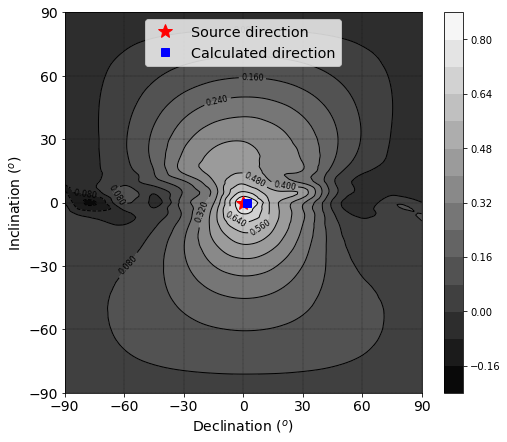

In [36]:
pyplot.figure(figsize=(8, 7))
fig5c = pyplot.contour(Deci.reshape(shapei), Inci.reshape(shapei), datai, 15, 
                       colors = 'k', linestyle = 'solid', linewidths = 1)
pyplot.contourf(Deci.reshape(shapei), Inci.reshape(shapei), datai, 15, cmap = pyplot.cm.gray)
pyplot.clabel(fig5c, fontsize = 8)
pyplot.plot(decs, incs, 'r*', label = 'Source direction', markersize = 15)
pyplot.plot(deci, inci, 'bs', label = 'Calculated direction', markersize = 8)
pyplot.xlabel('Declination $(^o)$', fontsize = 14)
pyplot.ylabel('Inclination $(^o)$', fontsize = 14)
pyplot.xticks(numpy.linspace(Deci.min(), Deci.max(), 7), fontsize = 14)
pyplot.yticks(numpy.linspace(Inci.min(), Inci.max(), 7), fontsize = 14)
pyplot.legend(loc = 'upper center', fontsize = 'x-large')
pyplot.colorbar()
pyplot.grid(color = 'k', linestyle='--', linewidth = .25)
pyplot.show()

In [31]:
rtp_final = equivalentlayer.rtp_layer(data, shape, eqlayer, shape_layer, 0.0001, inc, dec, incmaxfull, decmaxfull)

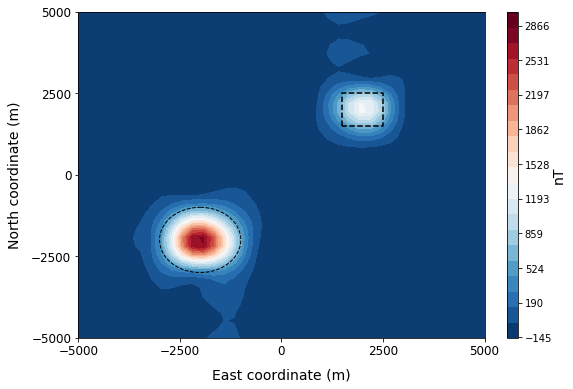

In [33]:
pyplot.figure(figsize=(8,6))
cs = pyplot.contourf(yo.reshape(shape), xo.reshape(shape), rtp_final.reshape(shape), 
                     20, cmap = pyplot.cm.RdBu_r)
plot.draw_prism(prisma[:4], linewidth = 0.5, style = 'k--', xy2ne = True)
pyplot.plot(ys, xs, 'k--', linewidth = 1.)
pyplot.xlabel('East coordinate (m)', fontsize = 14, labelpad = 10)
pyplot.ylabel('North coordinate (m)', fontsize = 14, labelpad = 10)
pyplot.xticks(numpy.linspace(yo.min(), yo.max(), 5), fontsize = 12)
pyplot.yticks(numpy.linspace(xo.min(), xo.max(), 5), fontsize = 12)

cb = pyplot.colorbar(cs, aspect = 30, fraction = 0.04, orientation = 'vertical', pad = 0.05)
cb.set_ticks(numpy.linspace(rtp_final.min(), rtp_final.max(), 10))
cb.set_clim(rtp_final.min(), rtp_final.max())
cb.set_label('nT', fontsize = 14, labelpad = 0.)
pyplot.show()